In [5]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization, GRU ,concatenate
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from keras.models import Model
from nltk import word_tokenize
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import collections
import nltk
import os
%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
df_tags = pd.read_csv('/content/drive/MyDrive/StackOverFlow-Classification-master/StackOverFlow-Classification-master/data/Tags.csv', encoding='iso-8859-1')

In [7]:
df_tags.shape

(3750994, 2)

In [8]:
df_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [9]:
def ptags(Count):
    x,y = zip(*Count)
    colormap = plt.cm.gist_ncar
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]
    plt.figure(figsize=(9,8))
    plt.ylabel("No. of Question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])
    plt.legend(numpoints=1)
    plt.show()

In [10]:
Count = collections.Counter(list(df_tags['Tag'])).most_common(10)
x = [i[0] for i in Count]
y = [i[1] for i in Count]

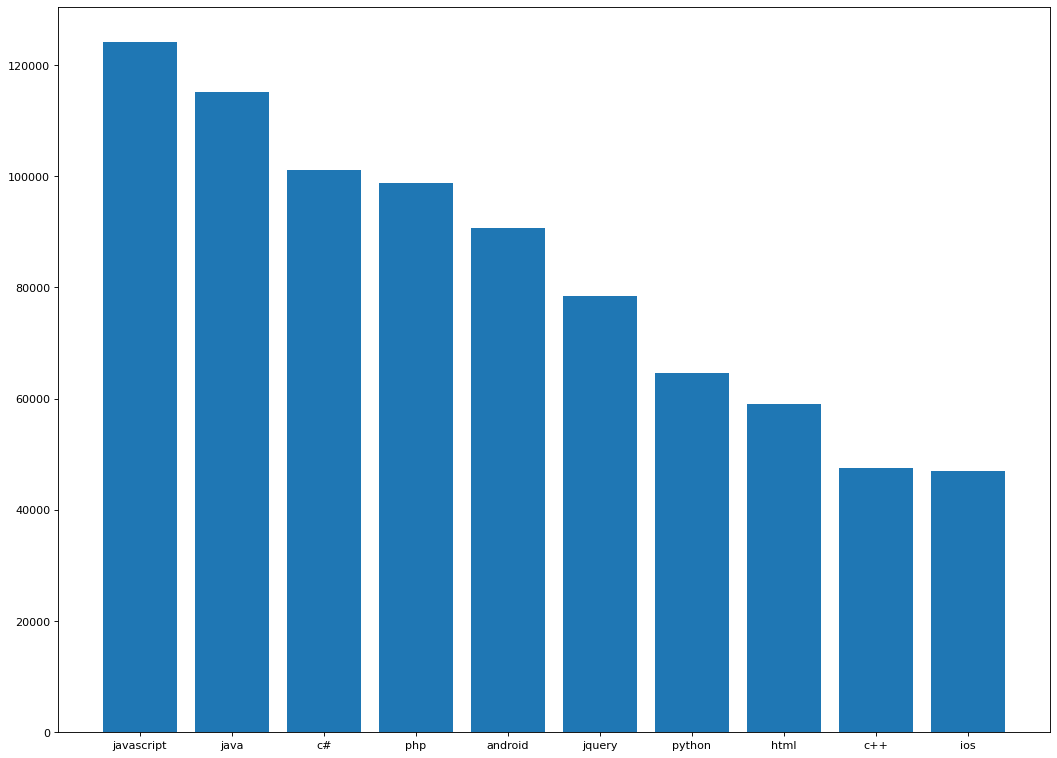

In [11]:
figure(figsize=(16, 12), dpi=80)
plt.bar(x, y)
plt.show()

In [12]:
tag=['javascript','java','c#','php','android','jquery','python','html','c++','ios']

In [13]:
tag_top_10= df_tags[df_tags.Tag.isin(tag)]
print (tag_top_10.shape)
tag_top_10.head()

(826739, 2)


,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [14]:
tag_top_10['Id'].value_counts().head(10)

4009250     5
30798790    5
30289880    5
23484760    5
35318730    5
23267320    5
30991580    5
31085960    5
35283570    5
11648170    5
Name: Id, dtype: int64

In [15]:
tag_top_10.head()

,Id,Tag
14,260,c#
18,330,c++
28,650,c#
35,930,c#
39,1010,c#


In [16]:
def add_tags(question_id):
    return tag_top_10[tag_top_10['Id'] == question_id['Id']].Tag.values
top_10 = tag_top_10.apply(add_tags, axis=1)

In [17]:
len(top_10),tag_top_10.shape

(826739, (826739, 2))

In [18]:
tag_top_10=pd.concat([tag_top_10, top_10.rename('Tags')], axis=1)
tag_top_10.head()

,Id,Tag,Tags
14,260,c#,[c#]
18,330,c++,[c++]
28,650,c#,[c#]
35,930,c#,[c#]
39,1010,c#,[c#]


In [19]:
tag_top_10.drop("Tag", axis=1, inplace=True)
tag_top_10.shape

(826739, 2)

In [20]:
top_10.sample(10)

3531271                        [html]
3521280                          [c#]
2175510    [javascript, jquery, html]
1020472                          [c#]
484482                          [php]
601262                         [html]
1700581                  [javascript]
2115901    [javascript, jquery, html]
2896799                        [java]
1550356                         [php]
dtype: object

In [21]:
top_10_tags=tag_top_10.loc[tag_top_10.astype(str).drop_duplicates().index]

In [22]:
ques = pd.read_csv('/content/drive/MyDrive/StackOverFlow-Classification-master/StackOverFlow-Classification-master/data/question_clean.csv', encoding='iso-8859-1')
ques.head()

,Id,Title,Body
0,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...
1,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...
2,120,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...
3,180,Function for creating color wheels,This is something I've pseudo-solved many time...
4,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...


In [23]:
ques.shape

(1264216, 3)

In [24]:
total=pd.merge(ques, top_10_tags, on='Id')
print(total.shape)
total.head()

(706336, 4)


,Id,Title,Body,Tags
0,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,[c#]
1,330,Should I use nested classes in this case?,I am working on a collection of classes used f...,[c++]
2,650,Automatically update version number,I would like the version property of my applic...,[c#]
3,930,How do I connect to a database and loop over a...,What's the simplest way to connect and query a...,[c#]
4,1010,"How to get the value of built, encoded ViewState?",I need to grab the base64-encoded representati...,[c#]


In [25]:
mb = MultiLabelBinarizer()
mb.fit(total.Tags)
labels = mb.classes_
labels

array(['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript',
       'jquery', 'php', 'python'], dtype=object)

In [26]:
train,test=train_test_split(total[:550000],test_size=0.25,random_state=24)

In [27]:
train.shape,test.shape

((412500, 4), (137500, 4))

In [28]:
X_train_t=train['Title']
X_train_b=train['Body']
y_train=mb.transform(train['Tags'])
X_test_t=test['Title']
X_test_b=test['Body']
y_test=mb.transform(test['Tags'])

In [29]:
st=[]
for sent in train['Title']:
    st.append(len(word_tokenize(sent)))
max(st)

59

In [30]:
np.quantile(st,0.97)

18.0

In [31]:
mt = 18
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_t)
sequences_train_t = tok.texts_to_sequences(X_train_t)

In [32]:
vt=len(tok.index_word.keys())
vt

68969

In [33]:
sequences_matrix_train_t = sequence.pad_sequences(sequences_train_t,maxlen=mt)
sequences_matrix_train_t

array([[    0,     0,     0, ...,     1,   957,   197],
       [    0,     0,     0, ...,  9081,    45,   533],
       [    0,     0,     0, ...,   147,     8,   230],
       ...,
       [    0,     0,     0, ...,    10,    71,  2985],
       [    0,     0,     0, ...,     2,    18,    75],
       [    0,     0,     0, ..., 11009,   809,   267]], dtype=int32)

In [34]:
sequences_test_t = tok.texts_to_sequences(X_test_t)
sequences_matrix_test_t = sequence.pad_sequences(sequences_test_t,maxlen=mt)

In [35]:
sequences_matrix_train_t.shape,sequences_matrix_test_t.shape,y_train.shape,y_test.shape

((412500, 18), (137500, 18), (412500, 10), (137500, 10))

In [36]:
sb=[]
for sent in train['Body']:
    sb.append(len(word_tokenize(sent)))
max(sb)

20853

In [37]:
np.quantile(sb,0.90)

575.0

In [38]:
mb = 600
tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(X_train_b)
sequences_train_b = tok.texts_to_sequences(X_train_b)

In [ ]:
vb =len(tok.index_word.keys())
vb 

In [ ]:
sequences_matrix_train_b = sequence.pad_sequences(sequences_train_b,maxlen=mb)
sequences_matrix_train_b

In [41]:
sequences_test_b = tok.texts_to_sequences(X_test_b)
sequences_matrix_test_b = sequence.pad_sequences(sequences_test_b,maxlen=mb)

In [ ]:
sequences_matrix_train_t.shape,sequences_matrix_train_b.shape,y_train.shape

In [ ]:
sequences_matrix_test_t.shape,sequences_matrix_test_b.shape,y_test.shape

In [ ]:
def RNN():
    # Title Only
    title_input = Input(name='title_input',shape=[mt])
    title_Embed = Embedding(vt+1,2000,input_length=mt,mask_zero=True,name='title_Embed')(title_input)
    gru_out_t = GRU(300)(title_Embed)
    # auxiliary output to tune GRU weights smoothly 
    auxiliary_output = Dense(10, activation='sigmoid', name='aux_output')(gru_out_t)   
    
    # Body Only
    body_input = Input(name='body_input',shape=[mb]) 
    body_Embed = Embedding(vb+1,170,input_length=mb,mask_zero=True,name='body_Embed')(body_input)
    gru_out_b = GRU(200)(body_Embed)
    
    # combined with GRU output
    com = concatenate([gru_out_t, gru_out_b])
    
    # now the combined data is being fed to dense layers
    dense1 = Dense(400,activation='relu')(com)
    dp1 = Dropout(0.5)(dense1)
    bn = BatchNormalization()(dp1) 
    dense2 = Dense(150,activation='relu')(bn)
    
    main_output = Dense(10, activation='sigmoid', name='main_output')(dense2)
    
    model = Model(inputs=[title_input, body_input],outputs=[main_output, auxiliary_output])
    return model

In [45]:
model = RNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_input (InputLayer)       [(None, 18)]         0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 600)]        0           []                               
                                                                                                  
 title_Embed (Embedding)        (None, 18, 2000)     137940000   ['title_input[0][0]']            
                                                                                                  
 body_Embed (Embedding)         (None, 600, 170)     219643230   ['body_input[0][0]']             
                                                                                              

In [46]:
model.compile(optimizer='adam',loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [ ]:
results=model.fit({'title_input': sequences_matrix_train_t, 'body_input': sequences_matrix_train_b},
          {'main_output': y_train, 'aux_output': y_train},
          validation_data=[{'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},
          {'main_output': y_test, 'aux_output': y_test}],
          epochs=5, batch_size=80)

Epoch 1/5
 626/5157 [==>...........................] - ETA: 3:07:07 - loss: 18.2579 - main_output_loss: 15.7548 - aux_output_loss: 2.5031 - main_output_accuracy: 0.2428 - aux_output_accuracy: 0.4199

In [ ]:
(predicted_main, predicted_aux)=model.predict({'title_input': sequences_matrix_test_t, 'body_input': sequences_matrix_test_b},verbose=1)

In [ ]:
from sklearn.metrics import classification_report,f1_score

In [ ]:
print(f1_score(y_test,predicted_main>.55,average='samples'))

In [ ]:
print(classification_report(y_test,predicted_main>.55))

In [ ]:
test.iloc[24]

In [ ]:
predicted_main[24].round(decimals = 2)

In [ ]:
labels

In [ ]:
model.save('./stackoverflow_tags.h5')